# Bike Sharing Demand Prediction

This notebook trains and compares regression models to predict bike rental demand.


In [15]:
# Imports
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt


In [16]:
# Load data
DATA_PATH = os.path.join("data", "bike_sharing.csv")
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Missing {DATA_PATH}."
    )

df = pd.read_csv(DATA_PATH)
df.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [17]:
# Basic inspection
print("Shape:", df.shape)
display(df.describe(include="all").T.head(30))
print("\nMissing values (top):")
display(df.isna().sum().sort_values(ascending=False).head(20))


Shape: (17379, 17)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
instant,17379.0,NaN,NaN,NaN,8690.0,5017.0295,1.0,4345.5,8690.0,13034.5,17379.0
dteday,17379,731,2011-01-01,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,17379.0,NaN,NaN,NaN,2.50164,1.106918,1.0,2.0,3.0,3.0,4.0
yr,17379.0,NaN,NaN,NaN,0.502561,0.500008,0.0,0.0,1.0,1.0,1.0
mnth,17379.0,NaN,NaN,NaN,6.537775,3.438776,1.0,4.0,7.0,10.0,12.0
hr,17379.0,NaN,NaN,NaN,11.546752,6.914405,0.0,6.0,12.0,18.0,23.0
holiday,17379.0,NaN,NaN,NaN,0.02877,0.167165,0.0,0.0,0.0,0.0,1.0
weekday,17379.0,NaN,NaN,NaN,3.003683,2.005771,0.0,1.0,3.0,5.0,6.0
workingday,17379.0,NaN,NaN,NaN,0.682721,0.465431,0.0,0.0,1.0,1.0,1.0
weathersit,17379.0,NaN,NaN,NaN,1.425283,0.639357,1.0,1.0,1.0,2.0,4.0



Missing values (top):


instant       0
weathersit    0
registered    0
casual        0
windspeed     0
hum           0
atemp         0
temp          0
workingday    0
dteday        0
weekday       0
holiday       0
hr            0
mnth          0
yr            0
season        0
cnt           0
dtype: int64

## Target column detection

In [18]:
# Detect target column
if "cnt" in df.columns:
    target_col = "cnt"
elif "count" in df.columns:
    target_col = "count"
else:
    raise ValueError("Could not find target column. Expected 'cnt' (UCI) or 'count' (Kaggle).")

print("Using target column:", target_col)


Using target column: cnt


## Feature engineering


In [19]:
# Feature engineering for Kaggle-style datetime
df_fe = df.copy()

if "datetime" in df_fe.columns:
    dt = pd.to_datetime(df_fe["datetime"], errors="coerce")
    df_fe["year"] = dt.dt.year
    df_fe["month"] = dt.dt.month
    df_fe["day"] = dt.dt.day
    df_fe["hour"] = dt.dt.hour
    df_fe["weekday"] = dt.dt.weekday
    # Drop raw datetime
    df_fe = df_fe.drop(columns=["datetime"])


In [20]:
# Drop leakage / identifier columns if present
# UCI has: instant, dteday, casual, registered (casual/registered leak into cnt)
leakage_cols = [c for c in ["casual", "registered"] if c in df_fe.columns]
id_like_cols = [c for c in ["instant", "dteday"] if c in df_fe.columns]

drop_cols = leakage_cols + id_like_cols
if drop_cols:
    print("Dropping columns:", drop_cols)
    df_fe = df_fe.drop(columns=drop_cols)

# Separate features/target
y = df_fe[target_col].copy()
X = df_fe.drop(columns=[target_col])

print("Features shape:", X.shape, "| Target shape:", y.shape)
X.head()


Dropping columns: ['casual', 'registered', 'instant', 'dteday']
Features shape: (17379, 12) | Target shape: (17379,)


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


## Preprocessing & Train/Validation Split

- Numeric features → StandardScaler  
- Categorical features → OneHotEncoder (handle_unknown='ignore')  


In [21]:
# Identify categorical vs numeric columns
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
# Some datasets store categoricals as ints (season, weekday, weather). We'll treat "small integer" columns as categorical.
for c in X.columns:
    if c not in categorical_cols and pd.api.types.is_integer_dtype(X[c]):
        nunique = X[c].nunique(dropna=True)
        if nunique <= 20:  # heuristic
            categorical_cols.append(c)

categorical_cols = sorted(set(categorical_cols))
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Categorical columns: ['holiday', 'mnth', 'season', 'weathersit', 'weekday', 'workingday', 'yr']
Numeric columns: ['hr', 'temp', 'atemp', 'hum', 'windspeed']


In [22]:
# Build preprocessors
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)


## Modeling

We compare three regression models:
- Linear Regression (baseline)
- Random Forest Regressor
- Gradient Boosting Regressor


In [23]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    results.append({"model": name, "rmse": rmse, "r2": r2})

results_df = pd.DataFrame(results).sort_values(by="rmse")
results_df


,model,rmse,r2
1,RandomForest,41.466395,0.945699
2,GradientBoosting,69.026244,0.849532
0,LinearRegression,136.848228,0.408584


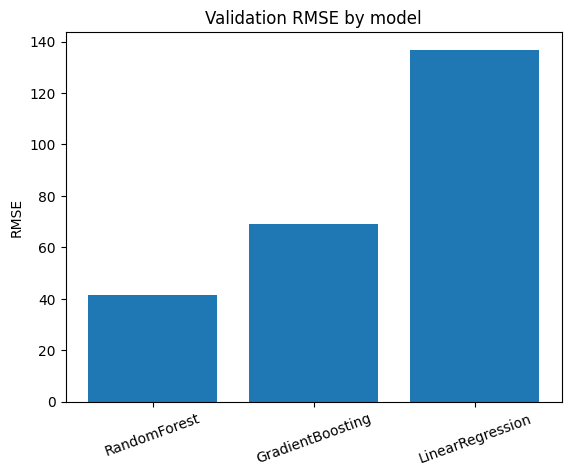

In [24]:
# Quick visualization (RMSE)
plt.figure()
plt.bar(results_df["model"], results_df["rmse"])
plt.title("Validation RMSE by model")
plt.ylabel("RMSE")
plt.xticks(rotation=20)
plt.show()


## Discussion 

Tree-based models significantly outperformed linear regression, indicating strong non-linear relationships between temporal and weather features and bike rental demand. The Random Forest model achieved the best performance, with an R² of approximately 0.95 and the lowest RMSE. While linear regression offered interpretability, its poor performance highlighted the limitations of linear assumptions for this problem. This tradeoff demonstrates the importance of model selection based on data structure and application goals.
